In [214]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from nemo import evaluate_nemo
import util
from topology import get_lognorm_hist
import topology
from util import evaluate
import pandas as pd
import random
from nemo import NemoSolver
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [215]:
# Specify the directory path
directory_path = 'datasets/RIPEAtlas/02072023/coords/'

# Iterate over all files in the directory
coord_dict = {}
for filename in os.listdir(directory_path):
    # Check if it's a file (not a directory)
    file = os.path.join(directory_path, filename)
    if os.path.isfile(file):
        df = topology.coords_ripe_atlas(file)
        
        coords = df[["x", "y"]].to_numpy()
        c_coords = coords[0]
        df['latency'] = list(zip(df.x, df.y))
        df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - c_coords))
        f = filename.replace(".csv", "")
        f = int(f.replace("time-", ""))
        coord_dict[f] = df
        
coord_list = []
for i in sorted(coord_dict.keys()):
    coord_list.append(coord_dict[i])
        

t_label = 0
coords_df = coord_dict[t_label]
s_dict = {t_label: coords_df}
avg = 50
c_capacity = 50
seed = 10
H, bins = get_lognorm_hist()

device_number = coords_df.shape[0]
max_resources = device_number * avg - c_capacity

df_dict_topologies = topology.create_topologies_from_dict(s_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=10, kmax=30, kseed=seed)
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
num_clusters = prim_df["cluster"].nunique() - 1
prim_df

Creating df for 0
Optimal k is 10
Done


,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1
0,66.727935,0.674971,0.000000,coordinator,9223372036854775807,0,50,50,50,50,50,50,50,50,50,50,50,50,-1,1
1,30.949951,0.390067,35.779119,worker,9223372036854775807,1,50,50,54,55,51,35,35,55,51,44,93,0,0,1
2,74.210686,6.956255,9.769651,worker,9223372036854775807,1,50,53,51,58,61,40,42,58,31,59,14,19,0,1
3,61.158745,8.060842,9.250242,worker,9223372036854775807,3,50,49,52,47,61,70,75,49,26,33,14,48,0,1
4,50.486977,20.730219,25.806621,worker,9223372036854775807,9,50,49,53,51,43,68,52,45,55,23,98,98,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,40.730184,11.636341,28.214087,worker,9223372036854775807,1,50,48,53,57,47,70,34,40,72,23,19,30,0,1
627,-125.173187,146.157101,240.813394,worker,9223372036854775807,1,50,50,51,44,65,47,55,36,28,126,28,8,9,1
628,-62.996618,43.422359,136.586232,worker,9223372036854775807,5,50,50,54,61,41,60,73,33,24,35,63,51,5,1
629,-248.870818,29.037346,316.870632,worker,9223372036854775807,6,50,53,48,44,43,71,56,29,24,18,33,11,1,1


In [216]:
coord_dict.keys()

dict_keys([16, 8, 0, 2, 18, 22, 14, 4, 11, 21, 20, 1, 3, 9, 17, 13, 15, 5, 12, 19, 10, 23, 6, 7])

In [217]:
coord_dict[t_label]

,x,y,latency
0,66.727935,0.674971,0.000000
1,30.949951,0.390067,35.779119
2,74.210686,6.956255,9.769651
3,61.158745,8.060842,9.250242
4,50.486977,20.730219,25.806621
...,...,...,...
626,40.730184,11.636341,28.214087
627,-125.173187,146.157101,240.813394
628,-62.996618,43.422359,136.586232
629,-248.870818,29.037346,316.870632


In [218]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 3998 Available: 31550


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

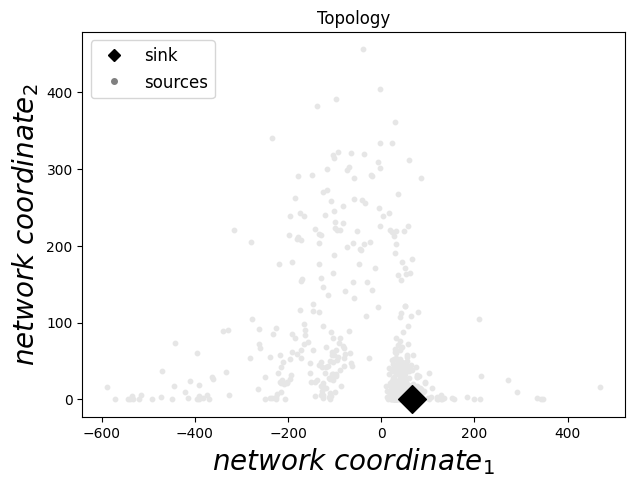

In [219]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, scale_fac=0.1)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")

plt.show()

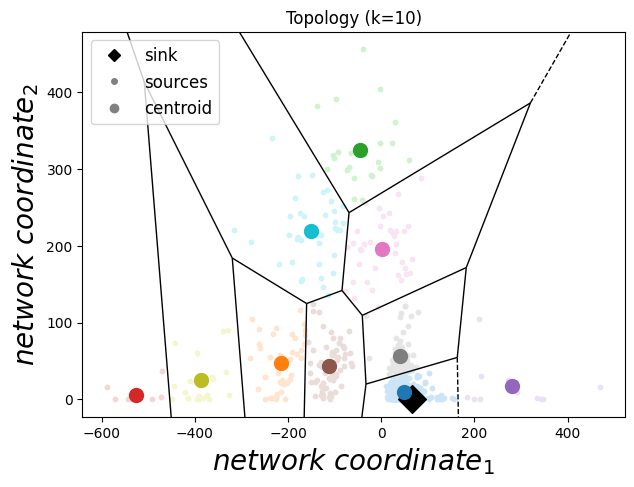

In [220]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.1,
                         plot_voronoi=True, plot_centroid=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_grouped.svg", bbox_inches="tight")

plt.show()

## Changing Topology

In [221]:
param_dict = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.1},
    "weight_2": {"merge_factor": 0.9, "step_size": 0.2},
    "weight": {"merge_factor": 0.4, "step_size": 0.4},
}

In [222]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight_1"

evaluations = []
evaluations_full = []
placement_df = None

for i, coords_df in enumerate(coord_list):
    df = prim_df.copy()
    df["x"] = coords_df["x"]
    df["y"] = coords_df["y"]
    df["latency"] = coords_df["latency"]
    df["weight_1"] = 1
    df.loc[0, "weight_1"] = 0
    df, centroids, opt_k, sil = topology.add_kmeans_labels(df, kmin=num_clusters, kmax=num_clusters)
    
    eval_matrix, df_dict, opt_dict, limits_dict = evaluate_nemo(df, [slot_col], weight_col,
                                               merge_factor=param_dict[weight_col][
                                                   "merge_factor"],
                                               step_size=param_dict[weight_col]["step_size"],
                                               with_eval=True)
    if i == 0:
        placement_df = df_dict[slot_col].copy()
    
    if limits_dict[slot_col] == True:
        break
    
    evaluations_full.append(eval_matrix[slot_col])
    
    if i > 0:
        update_df = coords_df[["x", "y"]]
        df = util.update_coordinates(placement_df, update_df)
        edf = evaluate(df)
    else:
        edf = eval_matrix[slot_col]
    evaluations.append(edf)

Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.1, merge_factor=0.1
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  18
Evaluating for capacity_100
Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.1, merge_factor=0.1
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  18
Evaluating for capacity_100
Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.1, merge_factor=0.1
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  17
Evaluating for capacity_100
Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.1, merge_factor=0.1
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  18
Evaluating for capacity_100
Optimal k is 10
Starting nemo fo

In [223]:
s = 3
evaluations[s].sort_index()

,latency_distribution,received_packets
0,0.000000,18.0
1,17.984015,0.0
2,17.713634,0.0
3,14.118810,0.0
4,16.629049,0.0
...,...,...
626,26.536335,0.0
627,387.159069,0.0
628,145.474845,0.0
629,257.108102,0.0


In [224]:
evaluations_full[s].sort_index()

,latency_distribution,received_packets
0,0.000000,18.0
1,20.227727,0.0
2,23.342616,0.0
3,21.054589,0.0
4,23.296021,0.0
...,...,...
626,30.662107,0.0
627,252.001313,0.0
628,210.528882,0.0
629,242.594350,0.0


## Evaluation

#### Latency

In [225]:
colors, light_colors, palette = util.get_color_list(11)

eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6],
    "nemo_pen": colors[7],
    "nemo_pen_base": colors[8],
    "nemo_dc_weight_2": colors[9],
    "nemo_dc_weight": colors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
}


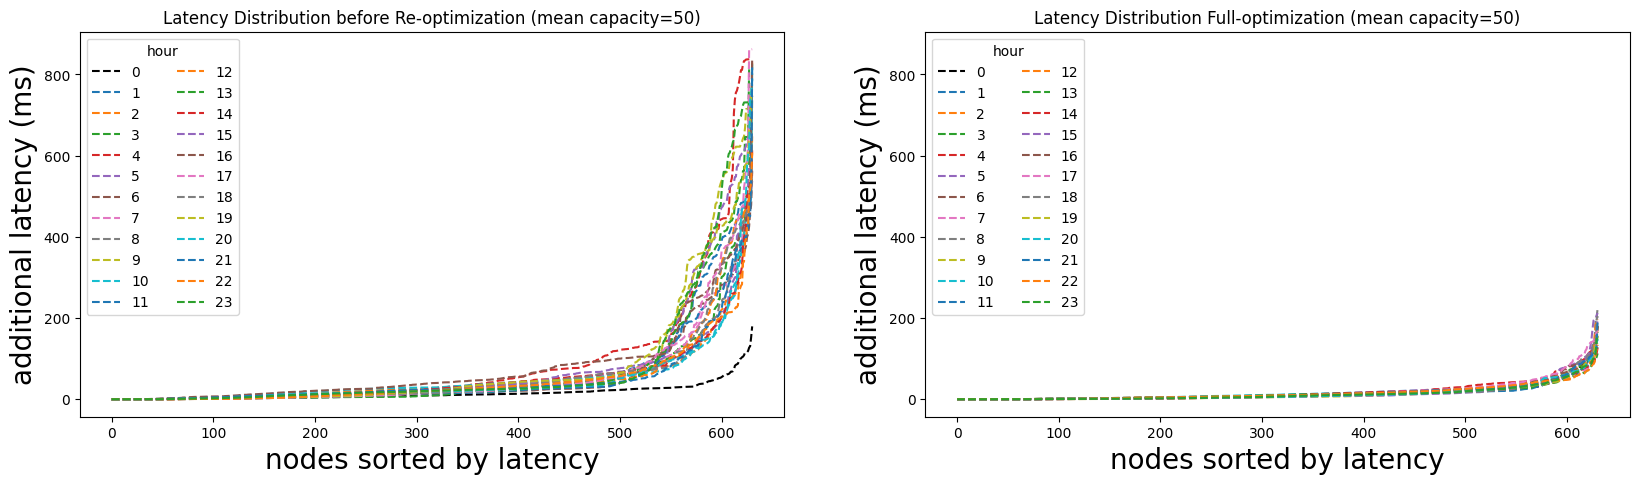

In [226]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=False)
quant_dict = {}
mean_dict = {}
prim_eval = coord_dict[t_label]["latency"]
nodes_take = 200
changed_nodes = {}

for i in range(len(evaluations)):
    l = str(i)
    sv1 = evaluations[i].sort_index()["latency_distribution"]
    sv2 = coord_list[i].sort_index()["latency"]
    sv = sv1 - sv2
    sv = sv.sort_values()
    
    if i > 0:
        changed_nodes[i] = list(sv.index[-nodes_take:]) # Get the last 100 indexes

    if i == 0:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--")
        
    sv1 = evaluations_full[i].sort_index()["latency_distribution"]
    sv = sv1 - sv2
    sv = sv.sort_values()
    
    if i > 0:
        changed_nodes[i] = list(sv.index[-nodes_take:]) # Get the last 100 indexes

    if i == 0:
        sv.plot(ax=ax2, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax2, use_index=False, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('additional latency (ms)')
ax1.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")

ax2.set_xlabel('nodes sorted by latency')
ax2.set_ylabel('additional latency (ms)')
ax2.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")
# Display a figure.
# plt.ylim([0, 100])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)
ax2.yaxis.label.set_size(20)
ax2.xaxis.label.set_size(20)
ylim_orig = ax1.get_ylim()
ax2.set_ylim(ylim_orig)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution before Re-optimization (mean capacity=' + str(avg) + ")")
ax2.set_title('Latency Distribution Full-optimization (mean capacity=' + str(avg) + ")")
plt.show()

## Test Reoptimization

In [227]:
i = 0
ndf = prim_df.copy()
ndf["x"] = coord_list[i]["x"]
ndf["y"] = coord_list[i]["y"]

nemo = NemoSolver(ndf, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                  merge_factor=param_dict[weight_col]["merge_factor"])
df, opts, limits = nemo.nemo_full()

edf = util.evaluate(df)
evaluations[i] = edf
print(df["oindex"].nunique())
df

Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  18
631


,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,66.727935,0.674971,coordinator,-1,<NA>,<NA>,<NA>,50,32,2,<NA>,18
1,1,30.949951,0.390067,worker,0,1,0,1,50,50,0,483,0
2,2,74.210686,6.956255,worker,0,1,0,1,50,50,0,623,0
3,3,61.158745,8.060842,worker,0,1,0,1,50,50,0,623,0
4,4,50.486977,20.730219,worker,0,1,0,1,50,50,0,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,626,40.730184,11.636341,worker,0,1,0,1,50,50,0,128,0
627,627,-125.173187,146.157101,worker,9,1,0,1,50,50,0,139,0
628,628,-62.996618,43.422359,worker,5,1,0,1,50,50,0,591,0
629,629,-248.870818,29.037346,worker,1,1,0,1,50,50,0,308,0


In [179]:
eval_numbers = len(evaluations)
for i in range(1, eval_numbers):
    nodes = changed_nodes[i]
    print("Iteration", i)
    print("Nodes", nodes)
    df_re, opt_dict, resource_limit, level = nemo.remove_nodes(nodes)
    new_nodes = list()
    for node_idx in nodes:
        node = prim_df.iloc[node_idx].to_dict()
        node["x"] = coord_list[i].iloc[node_idx]["x"]
        node["y"] = coord_list[i].iloc[node_idx]["y"]
        node["capacity"] = node[slot_col]
        node["weight"] = node[weight_col]
        node["oindex"] = node_idx
        new_nodes.append(node)
        # new_idx, df_re, resource_limit = nemo.add_node(node)
    df_re, opt_dict, resource_limit, level = nemo.add_nodes(new_nodes, full_opt=True)
    if resource_limit:
        print("----------------Resource limit reached. Init full opt")
        coords_df = coord_list[i]
        df = prim_df.copy()
        df["x"] = coords_df["x"]
        df["y"] = coords_df["y"]
        df["latency"] = coords_df["latency"]
        df["weight_1"] = 1
        df.loc[0, "weight_1"] = 0
        df, centroids, opt_k, sil = topology.add_kmeans_labels(df, kmin=num_clusters, kmax=num_clusters)
    
        eval_matrix, df_dict, opt_dict, limits_dict = evaluate_nemo(df, [slot_col], weight_col,
                                                   merge_factor=param_dict[weight_col][
                                                       "merge_factor"],
                                                   step_size=param_dict[weight_col]["step_size"],
                                                   with_eval=True)
        
        if resource_limit:
            print("Resource Limit!!!!!!!!!")
            break
    
    update_df = coord_list[i][["x", "y"]]
    df = util.update_coordinates(df_re, update_df)
    edf = evaluate(df)
    evaluations[i] = edf.copy()

Iteration 1
Nodes [426, 243, 75, 43, 115, 487, 628, 187, 604, 376, 197, 17, 101, 458, 390, 341, 8, 225, 369, 595, 630, 272, 172, 589, 573, 95, 281, 621, 406, 626, 116, 61, 583, 227, 25, 121, 24, 276, 619, 625, 124, 584, 319, 267, 454, 601, 31, 404, 408, 144, 424, 57, 371, 51, 504, 389, 495, 250, 303, 120, 106, 591, 555, 165, 392, 162, 157, 332, 576, 530, 352, 374, 140, 537, 395, 261, 63, 574, 412, 264, 145, 211, 202, 310, 16, 624, 547, 419, 302, 307, 18, 464, 274, 465, 287, 469, 349, 535, 600, 453, 298, 579, 402, 502, 321, 117, 462, 489, 7, 572, 210, 49, 29, 99, 471, 206, 208, 153, 418, 81, 449, 541, 493, 90, 380, 348, 486, 590, 477, 463, 393, 606, 514, 429, 545, 494, 386, 69, 596, 580, 305, 575, 195, 533, 13, 460, 396, 94, 519, 213, 294, 154, 277, 400, 306, 357, 84, 278, 442, 164, 76, 207, 527, 403, 142, 256, 324, 6, 105, 470, 544, 399, 446, 398, 548, 447, 141, 499, 223, 370, 21, 114, 566, 242, 231, 407, 228, 627, 586, 451, 511, 199, 135, 226, 414, 515, 183, 134, 534, 233]
Node with I

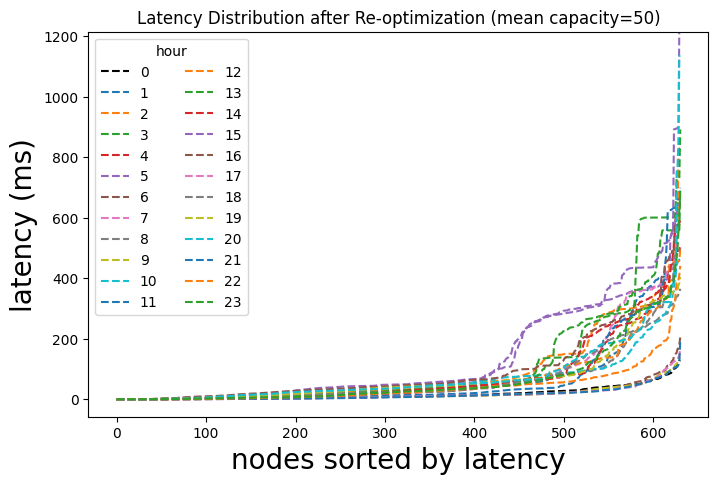

Means:  {'0': 17.08, '1': 68.41, '2': 85.34, '3': 102.1, '4': 73.17, '5': 121.21, '6': 17.07, '7': 76.05, '8': 56.51, '9': 16.12, '10': 59.38, '11': 63.71, '12': 65.96, '13': 96.35, '14': 66.53, '15': 129.55, '16': 92.33, '17': 15.72, '18': 64.95, '19': 67.03, '20': 75.27, '21': 14.77, '22': 40.15, '23': 64.13}
Quantiles:  {'0': 45.87, '1': 200.16, '2': 298.14, '3': 286.36, '4': 261.5, '5': 346.22, '6': 45.13, '7': 314.85, '8': 173.54, '9': 42.33, '10': 134.65, '11': 262.79, '12': 181.95, '13': 311.71, '14': 248.47, '15': 414.03, '16': 275.47, '17': 37.89, '18': 212.35, '19': 198.84, '20': 195.77, '21': 38.88, '22': 93.11, '23': 225.76}


In [180]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

for i in range(eval_numbers):
    l = str(i)
    sv1 = evaluations[i].sort_index()["latency_distribution"]
    sv2 = coord_list[i].sort_index()["latency"]
    sv = sv1 - sv2
    sv = sv.sort_values()

    quant_dict[l] = round(sv.quantile(0.9), 2)
    mean_dict[l] = round(sv.mean(), 2)
    sv = sv.to_numpy()

    if i == 0:
        ax1.plot(sv, label=l, linestyle="--", color="black")
    else:
        ax1.plot(sv, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")
# Display a figure.
# plt.ylim([0, 100])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_ylim(ylim_orig)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution after Re-optimization (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)